In [1]:
import numpy as np
import pandas as pd

def Peaks(x, y):
    z = 3*(1-x)**2 * np.exp(-(x**2) - (y+1)**2) - 10*(x/5 - x**3 - y**5) * np.exp(-x**2 - y**2) - 1/3 * np.exp(-(x+1)**2 - y**2)
    return z

def GetGrid(grid):
    x = np.linspace(-2, 2, grid)
    y = np.linspace(-2, 2, grid)
    x, y = np.meshgrid(x, y)
    z = Peaks(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_test = create_dataframe(grid=4)
df_training = create_dataframe(grid=5)

df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_593562/3623673326.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


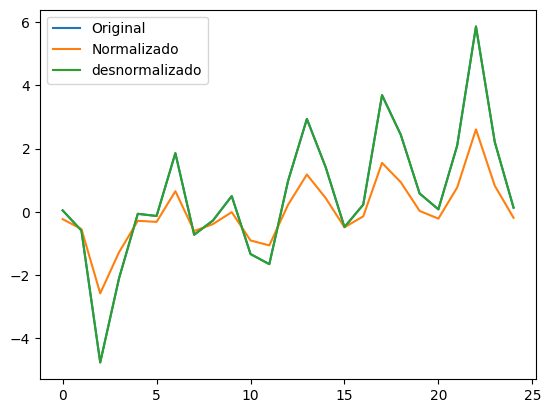

In [2]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [3]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...


remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 6.60 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-09-02 19:33:22.061689: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-02 19:33:22.061733: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-02 19:33:22.063006: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-02 19:33:22.069906: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


2024-09-02 19:33:24.113225: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [8]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[12, 2]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[12, 2], regularizer=0.02, learning_rate=0.01


+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 3 ++++++++++++++++++


Stopped at epoch:  7
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 4 ++++++++++++++++++


Stopped at epoch:  159
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_0] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_0] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_6,0.959713,0.754629,0.792833,0.917597,0.181475,1.640798,0.741025,0.380623,0.379777,0.425998,1.333803,0.433408,133.413279,268.453213
model_1_0_5,0.959089,0.753827,0.792463,0.916854,0.184288,1.646162,0.742349,0.384059,0.381937,0.429287,1.338977,0.436754,133.382514,268.422448
model_1_0_4,0.958452,0.753013,0.792084,0.916095,0.187157,1.651601,0.743705,0.387564,0.384121,0.432616,1.344255,0.440141,133.351616,268.391550
model_1_0_3,0.957802,0.752187,0.791692,0.915318,0.190086,1.657130,0.745106,0.391151,0.386319,0.435989,1.349643,0.443572,133.320557,268.360490
model_1_0_2,0.957138,0.751347,0.791289,0.914526,0.193076,1.662741,0.746546,0.394811,0.388550,0.439404,1.355142,0.447046,133.289346,268.329280
model_1_0_1,0.956460,0.750495,0.790876,0.913715,0.196129,1.668441,0.748025,0.398556,0.390799,0.442864,1.360758,0.450567,133.257966,268.297900
model_1_0_0,0.955769,0.749630,0.790450,0.912888,0.199242,1.674227,0.749549,0.402375,0.393065,0.446366,1.366485,0.454129,133.226466,268.266400


DataFrame salvo em ../results/metrics_1_0


+++++++++++ [1_1] | 1 ++++++++++++++++++


Stopped at epoch:  33
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 3 ++++++++++++++++++


Stopped at epoch: 

 6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 31ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_1] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.979749,0.775459,0.798177,0.983465,0.091224,1.501504,0.721911,0.104520,0.260825,0.302033,1.167796,0.307286,134.788882,269.828816
model_1_1_8,0.979378,0.774974,0.798245,0.983267,0.092892,1.504751,0.721667,0.105773,0.262703,0.304782,1.170865,0.310083,134.752628,269.792562
model_1_1_7,0.978999,0.774479,0.798306,0.983061,0.094599,1.508062,0.721447,0.107073,0.264567,0.307570,1.174005,0.312919,134.716211,269.756144
model_1_1_6,0.978611,0.773975,0.798355,0.982847,0.096347,1.511428,0.721273,0.108430,0.266414,0.310398,1.177219,0.315796,134.679603,269.719537
model_1_1_5,0.978215,0.773463,0.798394,0.982624,0.098132,1.514855,0.721132,0.109836,0.268212,0.313260,1.180503,0.318709,134.642885,269.682819
model_1_1_4,0.977810,0.772940,0.798421,0.982392,0.099959,1.518351,0.721038,0.111305,0.270813,0.316163,1.183864,0.321662,134.605988,269.645922
model_1_1_3,0.977395,0.772409,0.798432,0.982151,0.101828,1.521900,0.720997,0.112829,0.273854,0.319104,1.187301,0.324654,134.568948,269.608882
model_1_1_2,0.976970,0.771869,0.798429,0.981897,0.103743,1.525512,0.721006,0.114431,0.276939,0.322092,1.190824,0.327694,134.531678,269.571612
model_1_1_1,0.976536,0.771321,0.798414,0.981635,0.105697,1.529180,0.721060,0.116089,0.280111,0.325111,1.194418,0.330765,134.494356,269.534290
model_1_1_0,0.976092,0.770762,0.798382,0.981361,0.107698,1.532917,0.721174,0.117821,0.283470,0.328173,1.198098,0.333881,134.456852,269.496785


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++


Stopped at epoch:  36
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 2 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_2] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_2] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.985723,0.785049,0.808770,0.979806,0.064314,1.437380,0.684020,0.170537,0.192415,0.253602,1.118299,0.258013,135.487950,270.527884
model_1_2_8,0.985722,0.785008,0.808901,0.980143,0.064317,1.437655,0.683550,0.167687,0.193295,0.253609,1.118305,0.258020,135.487847,270.527781
model_1_2_7,0.985716,0.784958,0.809020,0.980478,0.064344,1.437987,0.683123,0.164861,0.194305,0.253661,1.118354,0.258073,135.487020,270.526954
model_1_2_6,0.985706,0.784893,0.809110,0.980809,0.064390,1.438419,0.682801,0.162067,0.195292,0.253752,1.118438,0.258165,135.485597,270.525531
model_1_2_5,0.985689,0.784825,0.809183,0.981132,0.064463,1.438874,0.682543,0.159340,0.196374,0.253897,1.118574,0.258312,135.483313,270.523247
model_1_2_4,0.985667,0.784749,0.809247,0.981446,0.064566,1.439387,0.682312,0.156688,0.197441,0.254097,1.118761,0.258517,135.480149,270.520083
model_1_2_3,0.985633,0.784641,0.809282,0.981744,0.064719,1.440105,0.682189,0.154169,0.198662,0.254400,1.119044,0.258825,135.475386,270.515319
model_1_2_2,0.985588,0.784532,0.809295,0.982011,0.064920,1.440834,0.682141,0.151912,0.199824,0.254794,1.119414,0.259226,135.469194,270.509128
model_1_2_1,0.985545,0.784426,0.809297,0.982294,0.065114,1.441548,0.682132,0.149523,0.201143,0.255174,1.119769,0.259612,135.463245,270.503179
model_1_2_0,0.985492,0.784300,0.809276,0.982557,0.065354,1.442390,0.682208,0.147306,0.202498,0.255645,1.120212,0.260091,135.455869,270.495803


DataFrame salvo em ../results/metrics_1_2


+++++++++++ [1_3] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_3] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_3] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.987928,0.787414,0.809571,0.953145,0.054379,1.421565,0.681153,0.089213,0.168662,0.233192,1.100024,0.237248,135.823568,270.863502
model_1_3_8,0.987725,0.787222,0.809531,0.952677,0.055296,1.422851,0.681298,0.090103,0.172203,0.235150,1.101710,0.239240,135.790122,270.830056
model_1_3_7,0.987518,0.787004,0.809476,0.952189,0.056228,1.424307,0.681494,0.091033,0.175638,0.237124,1.103425,0.241248,135.756683,270.796617
model_1_3_6,0.987307,0.786793,0.809449,0.951712,0.057177,1.425713,0.681591,0.091940,0.178821,0.239117,1.105171,0.243276,135.723204,270.763138
model_1_3_5,0.987094,0.786566,0.809406,0.951220,0.058135,1.427232,0.681745,0.092876,0.181047,0.241113,1.106933,0.245306,135.689967,270.729900
model_1_3_4,0.986879,0.786347,0.809330,0.950769,0.059105,1.428700,0.682017,0.093735,0.182644,0.243114,1.108716,0.247343,135.656895,270.696828
model_1_3_3,0.986656,0.786107,0.809266,0.950280,0.060111,1.430306,0.682245,0.094667,0.184665,0.245176,1.110568,0.249440,135.623113,270.663047
model_1_3_2,0.986429,0.785856,0.809169,0.949806,0.061133,1.431985,0.682590,0.095569,0.187033,0.247251,1.112447,0.251551,135.589413,270.629347
model_1_3_1,0.986198,0.785600,0.809062,0.949323,0.062171,1.433693,0.682975,0.096489,0.188843,0.249341,1.114357,0.253678,135.555735,270.595669
model_1_3_0,0.985962,0.785325,0.808919,0.948829,0.063234,1.435535,0.683485,0.097430,0.190623,0.251465,1.116313,0.255838,135.521813,270.561747


DataFrame salvo em ../results/metrics_1_3


+++++++++++ [1_4] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_4] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.989882,0.791000,0.809161,0.974353,0.045580,1.397582,0.682619,0.094603,0.170592,0.213494,1.083839,0.217207,136.176585,271.216519
model_1_4_8,0.989706,0.790657,0.809215,0.973993,0.046369,1.399875,0.682426,0.095930,0.169334,0.215334,1.085290,0.219079,136.142261,271.182195
model_1_4_7,0.989527,0.790307,0.809287,0.973625,0.047175,1.402219,0.682171,0.097285,0.167947,0.217198,1.086773,0.220975,136.107792,271.147725
model_1_4_6,0.989344,0.789969,0.809332,0.973250,0.048002,1.404478,0.682008,0.098671,0.166634,0.219095,1.088295,0.222905,136.073008,271.112942
model_1_4_5,0.989151,0.789564,0.809384,0.972805,0.048870,1.407188,0.681822,0.100310,0.165097,0.221066,1.089891,0.224911,136.037173,271.077107
model_1_4_4,0.988955,0.789184,0.809441,0.972376,0.049752,1.409726,0.681617,0.101892,0.163542,0.223051,1.091513,0.226930,136.001419,271.041353
model_1_4_3,0.988759,0.788834,0.809459,0.971965,0.050636,1.412068,0.681554,0.103410,0.162188,0.225025,1.093140,0.228939,135.966179,271.006113
model_1_4_2,0.988557,0.788472,0.809488,0.971528,0.051546,1.414489,0.681450,0.105022,0.160786,0.227037,1.094813,0.230986,135.930568,270.970502
model_1_4_1,0.988351,0.788121,0.809523,0.971096,0.052472,1.416834,0.681324,0.106616,0.162030,0.229069,1.096517,0.233053,135.894935,270.934869
model_1_4_0,0.988142,0.787774,0.809549,0.970662,0.053415,1.419156,0.681231,0.108218,0.165232,0.231118,1.098252,0.235138,135.859311,270.899245


DataFrame salvo em ../results/metrics_1_4


+++++++++++ [1_5] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 6 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 7 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_5] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_5] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.991469,0.796617,0.811818,0.994836,0.038429,1.360025,0.673116,0.018070,0.189744,0.196033,1.070686,0.199442,136.517891,271.557825
model_1_5_8,0.991334,0.796104,0.811662,0.994887,0.039037,1.363452,0.673675,0.017892,0.188085,0.197577,1.071804,0.201014,136.486502,271.526436
model_1_5_7,0.991194,0.795569,0.811459,0.994935,0.039668,1.367031,0.674401,0.017723,0.186026,0.199167,1.072964,0.202631,136.454446,271.494380
model_1_5_6,0.991048,0.795042,0.811272,0.994952,0.040324,1.370558,0.675070,0.017664,0.184118,0.200808,1.074171,0.204300,136.421629,271.461563
model_1_5_5,0.990899,0.794490,0.811084,0.994956,0.040995,1.374245,0.675740,0.017648,0.182200,0.202471,1.075405,0.205993,136.388632,271.428566
model_1_5_4,0.990744,0.793936,0.810849,0.994946,0.041695,1.377950,0.676584,0.017683,0.180173,0.204193,1.076693,0.207744,136.354763,271.394696
model_1_5_3,0.990585,0.793370,0.810585,0.994915,0.042413,1.381735,0.677527,0.017792,0.178441,0.205944,1.078014,0.209526,136.320606,271.360540
model_1_5_2,0.990422,0.792791,0.810271,0.994876,0.043147,1.385608,0.678651,0.017928,0.176399,0.207719,1.079365,0.211332,136.286274,271.326208
model_1_5_1,0.990249,0.792195,0.809932,0.994808,0.043924,1.389594,0.679861,0.018166,0.174443,0.209581,1.080794,0.213227,136.250572,271.290506
model_1_5_0,0.990071,0.791598,0.809563,0.994721,0.044727,1.393588,0.681183,0.018473,0.172303,0.211489,1.082271,0.215167,136.214335,271.254268


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++


Stopped at epoch:  23
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_6] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.993985,0.804923,0.813939,0.991329,0.027093,1.304483,0.665528,0.038819,0.220508,0.164599,1.049835,0.167462,137.216962,272.256896
model_1_6_8,0.993928,0.804690,0.813910,0.991469,0.027351,1.306038,0.665633,0.038190,0.219527,0.165382,1.050310,0.168259,137.197983,272.237917
model_1_6_7,0.993877,0.804449,0.813867,0.991637,0.027580,1.307647,0.665786,0.037436,0.218364,0.166073,1.050731,0.168961,137.181315,272.221248
model_1_6_6,0.993827,0.804204,0.813828,0.991816,0.027808,1.309286,0.665928,0.036636,0.216840,0.166758,1.051150,0.169659,137.164843,272.204777
model_1_6_5,0.993764,0.803934,0.813764,0.991954,0.028092,1.311095,0.666156,0.036021,0.215679,0.167607,1.051672,0.170522,137.144529,272.184463
model_1_6_4,0.993701,0.803643,0.813686,0.992089,0.028377,1.313041,0.666435,0.035413,0.214632,0.168454,1.052196,0.171384,137.124375,272.164309
model_1_6_3,0.993633,0.803345,0.813594,0.992215,0.028682,1.315034,0.666764,0.034851,0.213173,0.169357,1.052757,0.172303,137.102975,272.142909
model_1_6_2,0.993564,0.803043,0.813509,0.992345,0.028990,1.317051,0.667067,0.034271,0.211679,0.170265,1.053324,0.173227,137.081590,272.121524
model_1_6_1,0.993490,0.802738,0.813409,0.992457,0.029325,1.319095,0.667424,0.033769,0.210207,0.171244,1.053939,0.174223,137.058655,272.098589
model_1_6_0,0.993414,0.802427,0.813313,0.992569,0.029667,1.321169,0.667770,0.033268,0.208498,0.172240,1.054569,0.175236,137.035455,272.075389


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

27/32 [========================>.....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 5 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_7] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

29/32 [==========================>...] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_7] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 1s

 5/32 [===>..........................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

32/32 [==============================] - 0s 8ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_9,0.994809,0.807148,0.815819,0.994349,0.023384,1.289600,0.658803,0.025856,0.203514,0.152917,1.043012,0.155577,137.511431,272.551365
model_1_7_8,0.994734,0.806949,0.815674,0.994382,0.023721,1.290934,0.659324,0.025707,0.205077,0.154015,1.043631,0.156694,137.482825,272.522759
model_1_7_7,0.994657,0.806741,0.815522,0.994414,0.024067,1.292326,0.659867,0.025562,0.206663,0.155136,1.044269,0.157835,137.453800,272.493734
model_1_7_6,0.994579,0.806531,0.815365,0.994445,0.024421,1.293727,0.660430,0.025419,0.208264,0.156273,1.044920,0.158991,137.424615,272.464549
model_1_7_5,0.994500,0.806315,0.815189,0.994481,0.024777,1.295169,0.661058,0.025253,0.209900,0.157407,1.045574,0.160144,137.395692,272.435626
model_1_7_4,0.994418,0.806094,0.814996,0.994517,0.025143,1.296653,0.661750,0.025091,0.211610,0.158565,1.046248,0.161323,137.366353,272.406287
model_1_7_3,0.994336,0.805869,0.814800,0.994553,0.025515,1.298153,0.662451,0.024922,0.213283,0.159733,1.046931,0.162511,137.337012,272.376946
model_1_7_2,0.994252,0.805636,0.814583,0.994593,0.025891,1.299711,0.663227,0.024740,0.215058,0.160906,1.047623,0.163704,137.307743,272.347677
model_1_7_1,0.994166,0.805401,0.814367,0.994630,0.026279,1.301286,0.663997,0.024571,0.216881,0.162107,1.048337,0.164927,137.277992,272.317926
model_1_7_0,0.994078,0.805160,0.814144,0.994666,0.026676,1.302897,0.664796,0.024409,0.218682,0.163329,1.049068,0.166170,137.247950,272.287884


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 48ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_8] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_8] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_8] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.995483,0.809295,0.819041,0.993965,0.020346,1.275243,0.647281,0.029412,0.201322,0.142638,1.037423,0.145119,137.789790,272.829724
model_1_8_8,0.995429,0.809083,0.818721,0.994013,0.020589,1.276665,0.648424,0.029178,0.201036,0.143489,1.037871,0.145984,137.765997,272.805931
model_1_8_7,0.995374,0.808880,0.818428,0.994056,0.020840,1.278020,0.649472,0.028972,0.200311,0.144362,1.038333,0.146873,137.741732,272.781666
model_1_8_6,0.995313,0.808660,0.818116,0.994087,0.021112,1.279490,0.650590,0.028820,0.199880,0.145300,1.038833,0.147827,137.715826,272.755760
model_1_8_5,0.995251,0.808448,0.817794,0.994115,0.021392,1.280906,0.651739,0.028683,0.200327,0.146260,1.039348,0.148804,137.689480,272.729414
model_1_8_4,0.995186,0.808243,0.817491,0.994133,0.021685,1.282279,0.652824,0.028597,0.200975,0.147260,1.039888,0.149821,137.662223,272.702157
model_1_8_3,0.995117,0.808026,0.817171,0.994145,0.021994,1.283730,0.653967,0.028537,0.201596,0.148304,1.040456,0.150883,137.633970,272.673903
model_1_8_2,0.995046,0.807804,0.816817,0.994153,0.022315,1.285213,0.655235,0.028497,0.202095,0.149381,1.041045,0.151979,137.605028,272.644962
model_1_8_1,0.994970,0.807582,0.816485,0.994148,0.022657,1.286700,0.656423,0.028524,0.202646,0.150521,1.041674,0.153139,137.574605,272.614539
model_1_8_0,0.994892,0.807370,0.816158,0.994135,0.023011,1.288121,0.657591,0.028587,0.203155,0.151694,1.042327,0.154333,137.543550,272.583484


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++


Stopped at epoch:  16
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 4 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_9] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_9] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_9] | 10 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.994942,0.811915,0.820138,0.990669,0.022786,1.257724,0.643356,0.055120,0.250962,0.150949,1.041912,0.153575,137.563244,272.603178
model_1_9_8,0.994960,0.811837,0.820263,0.990925,0.022703,1.258245,0.642907,0.053606,0.250808,0.150675,1.041760,0.153296,137.570516,272.610450
model_1_9_7,0.995003,0.811779,0.820330,0.991250,0.022508,1.258635,0.642669,0.051683,0.249215,0.150028,1.041402,0.152638,137.587726,272.627660
model_1_9_6,0.995071,0.811768,0.820516,0.991679,0.022201,1.258711,0.642005,0.049150,0.247149,0.149000,1.040836,0.151592,137.615233,272.655167
model_1_9_4,0.995237,0.811745,0.820522,0.992569,0.021458,1.258864,0.641982,0.043894,0.244611,0.146484,1.039469,0.149032,137.683352,272.723286
model_1_9_3,0.995343,0.811691,0.820700,0.993138,0.020977,1.259220,0.641347,0.040533,0.242035,0.144836,1.038586,0.147355,137.728626,272.768560
model_1_9_5,0.995074,0.811614,0.820478,0.991872,0.022190,1.259740,0.642141,0.048012,0.246631,0.148962,1.040816,0.151553,137.616252,272.656186
model_1_9_2,0.995467,0.811358,0.820787,0.994221,0.020418,1.261452,0.641035,0.034134,0.236311,0.142891,1.037556,0.145376,137.782700,272.822634
model_1_9_1,0.995548,0.811244,0.820920,0.994756,0.020053,1.262215,0.640558,0.030974,0.234679,0.141610,1.036886,0.144073,137.818716,272.858650
model_1_9_0,0.995594,0.811146,0.820986,0.995145,0.019848,1.262870,0.640323,0.028678,0.232658,0.140883,1.036508,0.143333,137.839300,272.879234


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++


Stopped at epoch:  10
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_10] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_10] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.995746,0.814428,0.818153,0.996915,0.019163,1.240922,0.650458,0.020576,0.242928,0.138431,1.035248,0.140838,137.909543,272.949477
model_1_10_8,0.995706,0.814266,0.818307,0.997002,0.019344,1.242005,0.649905,0.020000,0.243049,0.139084,1.035582,0.141503,137.890712,272.930645
model_1_10_7,0.995663,0.814098,0.818457,0.997085,0.019537,1.243125,0.649369,0.019443,0.243132,0.139774,1.035936,0.142205,137.870901,272.910835
model_1_10_6,0.995616,0.813918,0.818586,0.997160,0.019748,1.244328,0.648907,0.018944,0.243213,0.140526,1.036323,0.142970,137.849455,272.889389
model_1_10_5,0.995567,0.813749,0.818722,0.997230,0.019968,1.245461,0.648421,0.018481,0.243312,0.141309,1.036730,0.143767,137.827217,272.867151
model_1_10_4,0.995518,0.813575,0.818863,0.997304,0.020189,1.246622,0.647918,0.017987,0.243577,0.142088,1.037136,0.144559,137.805232,272.845166
model_1_10_3,0.995464,0.813395,0.818998,0.997370,0.020435,1.247827,0.647433,0.017542,0.243531,0.142950,1.037587,0.145436,137.781052,272.820986
model_1_10_2,0.995407,0.813210,0.819138,0.997437,0.020688,1.249067,0.646931,0.017098,0.243736,0.143835,1.038054,0.146336,137.756367,272.796301
model_1_10_1,0.995349,0.813034,0.819270,0.997497,0.020950,1.250240,0.646462,0.016697,0.244016,0.144740,1.038535,0.147257,137.731268,272.771202
model_1_10_0,0.995287,0.812857,0.819422,0.997552,0.021228,1.251426,0.645918,0.016328,0.243969,0.145699,1.039047,0.148233,137.704839,272.744773


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_11] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_11] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.996326,0.814925,0.817559,0.996566,0.016549,1.237599,0.652580,0.009713,0.212057,0.128643,1.030440,0.130881,138.202852,273.242785
model_1_11_8,0.996282,0.814889,0.817680,0.996751,0.016746,1.237838,0.652146,0.009190,0.215621,0.129407,1.030803,0.131658,138.179174,273.219107
model_1_11_7,0.996236,0.814852,0.817773,0.996917,0.016956,1.238085,0.651814,0.008720,0.218764,0.130215,1.031189,0.132480,138.154263,273.194197
model_1_11_6,0.996185,0.814815,0.817885,0.997071,0.017184,1.238335,0.651414,0.008286,0.221872,0.131086,1.031607,0.133366,138.127596,273.167529
model_1_11_5,0.996132,0.814773,0.817968,0.997205,0.017426,1.238617,0.651117,0.007907,0.224870,0.132007,1.032053,0.134303,138.099590,273.139524
model_1_11_4,0.996075,0.814720,0.818027,0.997325,0.017682,1.238969,0.650908,0.007566,0.227823,0.132973,1.032524,0.135286,138.070429,273.110363
model_1_11_3,0.996017,0.814677,0.818082,0.997449,0.017943,1.239259,0.650710,0.007217,0.231280,0.133952,1.033005,0.136282,138.041085,273.081019
model_1_11_2,0.995954,0.814628,0.818106,0.997545,0.018228,1.239581,0.650623,0.006944,0.234472,0.135010,1.033528,0.137358,138.009626,273.049560
model_1_11_1,0.995886,0.814561,0.818115,0.997625,0.018534,1.240030,0.650592,0.006718,0.237524,0.136138,1.034091,0.138506,137.976338,273.016272
model_1_11_0,0.995817,0.814499,0.818130,0.997699,0.018844,1.240449,0.650538,0.006508,0.240286,0.137273,1.034661,0.139660,137.943149,272.983082


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 2 ++++++++++++++++++


Stopped at epoch: 

 6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_12] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.996377,0.814813,0.817541,0.995619,0.016321,1.238346,0.652645,0.017869,0.208713,0.127752,1.030020,0.129974,138.230664,273.270597
model_1_12_1,0.996419,0.814662,0.817573,0.995538,0.016133,1.239355,0.652531,0.018198,0.205295,0.127015,1.029675,0.129225,138.253785,273.293719
model_1_12_2,0.996456,0.814504,0.817578,0.995439,0.015963,1.240414,0.652514,0.018605,0.202653,0.126345,1.029362,0.128543,138.274954,273.314888
model_1_12_3,0.996493,0.814343,0.817576,0.995341,0.015799,1.241492,0.652520,0.019003,0.202309,0.125693,1.029060,0.127879,138.295643,273.335577
model_1_12_4,0.996530,0.814200,0.817557,0.995254,0.015633,1.242442,0.652587,0.019357,0.201828,0.125032,1.028755,0.127206,138.316748,273.356682
model_1_12_5,0.996566,0.814066,0.817541,0.995172,0.015467,1.243339,0.652644,0.019692,0.201335,0.124367,1.028450,0.126530,138.338076,273.378010
model_1_12_6,0.996594,0.813909,0.817524,0.995046,0.015341,1.244394,0.652706,0.020205,0.201037,0.123857,1.028217,0.126011,138.354505,273.394439
model_1_12_7,0.996627,0.813782,0.817532,0.994944,0.015195,1.245241,0.652676,0.020621,0.200669,0.123269,1.027950,0.125413,138.373548,273.413481
model_1_12_8,0.996656,0.813644,0.817545,0.994835,0.015066,1.246166,0.652629,0.021068,0.200322,0.122742,1.027711,0.124877,138.390689,273.430623
model_1_12_9,0.996684,0.813511,0.817534,0.994724,0.014937,1.247053,0.652669,0.021518,0.199881,0.122219,1.027476,0.124344,138.407776,273.447710


DataFrame salvo em ../results/metrics_1_12


+++++++++++ [1_13] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_13] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_13] | 10 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_0,0.996735,0.813511,0.817553,0.997774,0.014707,1.247056,0.652601,0.004643,0.197479,0.121274,1.027052,0.123383,138.438825,273.478759
model_1_13_1,0.996781,0.813478,0.817510,0.997686,0.014502,1.247274,0.652757,0.004827,0.194604,0.120423,1.026674,0.122517,138.466984,273.506918
model_1_13_2,0.996825,0.813447,0.817495,0.997586,0.014300,1.247484,0.652811,0.005036,0.192733,0.119583,1.026303,0.121662,138.494992,273.534926
model_1_13_4,0.996912,0.813421,0.817461,0.997365,0.013912,1.247654,0.652930,0.005496,0.191467,0.117947,1.025589,0.119999,138.550075,273.590009
model_1_13_3,0.996869,0.813421,0.817473,0.997475,0.014105,1.247655,0.652889,0.005267,0.192076,0.118765,1.025945,0.120831,138.522427,273.562361
model_1_13_5,0.996951,0.813401,0.817439,0.997231,0.013734,1.247786,0.653009,0.005775,0.190952,0.117194,1.025263,0.119232,138.575694,273.615628
model_1_13_6,0.996988,0.813381,0.817408,0.997092,0.013567,1.247920,0.653121,0.006067,0.190309,0.116478,1.024955,0.118504,138.600218,273.640152
model_1_13_7,0.997023,0.813336,0.817343,0.996944,0.013412,1.248226,0.653354,0.006375,0.189748,0.115808,1.024669,0.117822,138.623277,273.663211
model_1_13_8,0.997057,0.813312,0.817279,0.996794,0.013257,1.248385,0.653582,0.006687,0.189374,0.115141,1.024386,0.117144,138.646385,273.686319
model_1_13_9,0.997090,0.813278,0.817212,0.996644,0.013110,1.248609,0.653821,0.007000,0.188876,0.114500,1.024115,0.116491,138.668737,273.708671


DataFrame salvo em ../results/metrics_1_13


+++++++++++ [1_14] | 1 ++++++++++++++++++


Stopped at epoch:  67
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_14] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_14] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_9,0.997256,0.818282,0.833538,0.992497,0.012361,1.215146,0.595424,0.047702,0.258355,0.111181,1.022737,0.113115,138.786374,273.826307
model_1_14_8,0.997265,0.818193,0.833409,0.992574,0.012319,1.215741,0.595888,0.047209,0.257931,0.110989,1.022659,0.112920,138.793291,273.833225
model_1_14_7,0.997274,0.818101,0.833284,0.992649,0.012279,1.216362,0.596334,0.046734,0.257595,0.110812,1.022586,0.112739,138.799696,273.839630
model_1_14_6,0.997283,0.817990,0.833157,0.992723,0.012241,1.217103,0.596788,0.046263,0.257216,0.110640,1.022516,0.112564,138.805894,273.845827
model_1_14_5,0.997287,0.817897,0.833023,0.992782,0.012223,1.217725,0.597266,0.045890,0.257516,0.110557,1.022483,0.112480,138.808884,273.848818
model_1_14_4,0.997295,0.817793,0.832895,0.992857,0.012186,1.218422,0.597725,0.045414,0.257257,0.110391,1.022415,0.112311,138.814895,273.854829
model_1_14_3,0.997308,0.817680,0.832755,0.992950,0.012125,1.219176,0.598225,0.044820,0.256699,0.110114,1.022303,0.112029,138.824970,273.864904
model_1_14_2,0.997314,0.817567,0.832600,0.993016,0.012102,1.219930,0.598780,0.044402,0.256785,0.110007,1.022259,0.111920,138.828845,273.868779
model_1_14_1,0.997324,0.817482,0.832467,0.993103,0.012052,1.220497,0.599257,0.043846,0.256188,0.109784,1.022169,0.111693,138.836967,273.876901
model_1_14_0,0.997336,0.817371,0.832307,0.993195,0.011999,1.221239,0.599828,0.043265,0.255688,0.109539,1.022071,0.111445,138.845886,273.885820


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 11ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_15] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 7 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_15] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_9,0.997805,0.819116,0.832713,0.999022,0.009887,1.209571,0.598375,0.006803,0.233991,0.099433,1.018186,0.101163,139.233075,274.273009
model_1_15_8,0.997761,0.819047,0.832848,0.998995,0.010086,1.210031,0.597895,0.006989,0.235841,0.100430,1.018552,0.102177,139.193172,274.233106
model_1_15_7,0.997714,0.818989,0.832976,0.998960,0.010297,1.210418,0.597434,0.007229,0.238914,0.101472,1.018940,0.103237,139.151871,274.191805
model_1_15_6,0.997665,0.818921,0.833096,0.998919,0.010519,1.210876,0.597004,0.007514,0.241807,0.102560,1.019348,0.104344,139.109228,274.149162
model_1_15_5,0.997613,0.818837,0.833198,0.998870,0.010754,1.211440,0.596640,0.007857,0.244512,0.103701,1.019781,0.105505,139.064979,274.104913
model_1_15_4,0.997561,0.818761,0.833258,0.998822,0.010988,1.211943,0.596428,0.008193,0.247150,0.104826,1.020212,0.106649,139.021822,274.061756
model_1_15_3,0.997505,0.818676,0.833354,0.998765,0.011240,1.212513,0.596085,0.008587,0.249555,0.106020,1.020675,0.107864,138.976492,274.016426
model_1_15_2,0.997442,0.818569,0.833429,0.998690,0.011522,1.213232,0.595814,0.009105,0.252108,0.107339,1.021193,0.109206,138.927047,273.966981
model_1_15_1,0.997380,0.818484,0.833500,0.998618,0.011803,1.213799,0.595561,0.009609,0.254581,0.108641,1.021710,0.110530,138.878844,273.918778
model_1_15_0,0.997317,0.818394,0.833563,0.998545,0.012086,1.214402,0.595337,0.010114,0.256605,0.109935,1.022230,0.111847,138.831471,273.871404


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 8 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_16] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_9,0.998041,0.820297,0.830200,0.997342,0.008824,1.201674,0.607366,0.007761,0.233011,0.093935,1.016230,0.095568,139.460625,274.500559
model_1_16_8,0.998023,0.820198,0.830478,0.997453,0.008904,1.202340,0.606371,0.007439,0.233218,0.094360,1.016377,0.096001,139.442563,274.482497
model_1_16_7,0.998005,0.820089,0.830736,0.997563,0.008986,1.203066,0.605446,0.007116,0.233315,0.094794,1.016529,0.096443,139.424200,274.464134
model_1_16_6,0.997985,0.819978,0.830998,0.997667,0.009075,1.203809,0.604509,0.006813,0.233417,0.095265,1.016693,0.096922,139.404358,274.444291
model_1_16_5,0.997964,0.819865,0.831257,0.997763,0.009173,1.204567,0.603583,0.006531,0.233638,0.095775,1.016872,0.097441,139.383024,274.422958
model_1_16_4,0.997941,0.819751,0.831514,0.997859,0.009273,1.205323,0.602664,0.006251,0.233746,0.096295,1.017056,0.097970,139.361346,274.401280
model_1_16_3,0.997918,0.819632,0.831758,0.997949,0.009379,1.206124,0.601790,0.005989,0.233809,0.096848,1.017252,0.098532,139.338467,274.378401
model_1_16_2,0.997892,0.819508,0.832001,0.998028,0.009496,1.206951,0.600923,0.005759,0.233956,0.097449,1.017467,0.099143,139.313724,274.353658
model_1_16_1,0.997865,0.819384,0.832247,0.998104,0.009618,1.207781,0.600044,0.005537,0.233981,0.098071,1.017691,0.099777,139.288254,274.328188
model_1_16_0,0.997836,0.819249,0.832478,0.998174,0.009747,1.208683,0.599217,0.005332,0.233973,0.098725,1.017928,0.100443,139.261649,274.301583


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_17] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_17] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_0,0.998069,0.820209,0.830035,0.998472,0.008696,1.202262,0.607955,0.004297,0.231954,0.093254,1.015996,0.094876,139.489716,274.529650
model_1_17_1,0.998097,0.820131,0.829885,0.998415,0.008573,1.202783,0.608491,0.004458,0.231026,0.092592,1.015770,0.094203,139.518198,274.558132
model_1_17_2,0.998122,0.820051,0.829715,0.998345,0.008462,1.203317,0.609100,0.004654,0.232854,0.091988,1.015565,0.093588,139.544384,274.584318
model_1_17_3,0.998145,0.819975,0.829548,0.998269,0.008358,1.203831,0.609698,0.004866,0.234594,0.091423,1.015374,0.093013,139.569026,274.608960
model_1_17_4,0.998166,0.819875,0.829365,0.998187,0.008260,1.204495,0.610353,0.005098,0.236165,0.090883,1.015193,0.092463,139.592743,274.632677
model_1_17_5,0.998187,0.819778,0.829194,0.998102,0.008166,1.205148,0.610964,0.005337,0.237617,0.090367,1.015021,0.091939,139.615500,274.655434
model_1_17_6,0.998206,0.819665,0.829009,0.998009,0.008080,1.205902,0.611625,0.005598,0.239139,0.089887,1.014862,0.091450,139.636806,274.676740
model_1_17_7,0.998224,0.819555,0.828816,0.997910,0.008001,1.206639,0.612317,0.005878,0.240671,0.089448,1.014717,0.091004,139.656395,274.696329
model_1_17_8,0.998241,0.819430,0.828622,0.997813,0.007923,1.207470,0.613010,0.006151,0.241956,0.089010,1.014573,0.090558,139.676024,274.715958
model_1_17_9,0.998256,0.819325,0.828443,0.997702,0.007856,1.208171,0.613650,0.006462,0.243398,0.088635,1.014451,0.090177,139.692913,274.732847


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++


Stopped at epoch:  12
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_18] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_18] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_9,0.998615,0.819841,0.824297,0.997362,0.006241,1.204726,0.628478,0.010862,0.211306,0.078997,1.011479,0.080371,140.153378,275.193312
model_1_18_8,0.998597,0.819810,0.824520,0.997367,0.006318,1.204930,0.627683,0.010841,0.212991,0.079485,1.011621,0.080868,140.128736,275.168670
model_1_18_7,0.998580,0.819780,0.824742,0.997373,0.006395,1.205130,0.626889,0.010816,0.214585,0.079971,1.011764,0.081362,140.104350,275.144284
model_1_18_6,0.998562,0.819752,0.824972,0.997378,0.006476,1.205319,0.626066,0.010797,0.216305,0.080472,1.011911,0.081872,140.079374,275.119308
model_1_18_5,0.998544,0.819724,0.825215,0.997380,0.006559,1.205506,0.625195,0.010786,0.218131,0.080989,1.012065,0.082398,140.053768,275.093702
model_1_18_4,0.998524,0.819693,0.825457,0.997379,0.006648,1.205711,0.624330,0.010790,0.220057,0.081537,1.012229,0.082955,140.026806,275.066739
model_1_18_3,0.998504,0.819662,0.825702,0.997378,0.006739,1.205918,0.623455,0.010796,0.221986,0.082094,1.012396,0.083522,139.999571,275.039505
model_1_18_2,0.998483,0.819631,0.825950,0.997374,0.006834,1.206130,0.622567,0.010811,0.223910,0.082666,1.012570,0.084104,139.971798,275.011732
model_1_18_1,0.998461,0.819601,0.826207,0.997368,0.006931,1.206332,0.621647,0.010836,0.225881,0.083255,1.012750,0.084704,139.943365,274.983299
model_1_18_0,0.998439,0.819568,0.826468,0.997359,0.007034,1.206553,0.620713,0.010872,0.227896,0.083868,1.012938,0.085327,139.914038,274.953972


DataFrame salvo em ../results/metrics_1_18


+++++++++++ [1_19] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_19] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_19] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_9,0.998688,0.821508,0.828248,0.996330,0.005912,1.193580,0.614346,0.008548,0.212715,0.076888,1.010874,0.078225,140.261613,275.301547
model_1_19_8,0.998685,0.821350,0.827850,0.996472,0.005925,1.194635,0.615770,0.008217,0.212519,0.076974,1.010898,0.078312,140.257171,275.297105
model_1_19_7,0.998680,0.821185,0.827459,0.996603,0.005948,1.195735,0.617171,0.007914,0.212474,0.077122,1.010940,0.078463,140.249461,275.289395
model_1_19_6,0.998674,0.821018,0.827059,0.996734,0.005972,1.196850,0.618599,0.007608,0.212345,0.077280,1.010985,0.078624,140.241290,275.281224
model_1_19_5,0.998668,0.820854,0.826665,0.996861,0.006000,1.197952,0.620010,0.007312,0.212192,0.077457,1.011036,0.078804,140.232126,275.272060
model_1_19_4,0.998661,0.820688,0.826276,0.996985,0.006031,1.199061,0.621402,0.007023,0.212021,0.077659,1.011093,0.079010,140.221701,275.261635
model_1_19_3,0.998654,0.820516,0.825869,0.997107,0.006065,1.200208,0.622856,0.006740,0.211823,0.077876,1.011155,0.079231,140.210534,275.250468
model_1_19_2,0.998645,0.820348,0.825477,0.997219,0.006104,1.201336,0.624259,0.006478,0.211695,0.078131,1.011228,0.079489,140.197495,275.237429
model_1_19_1,0.998636,0.820182,0.825091,0.997330,0.006146,1.202440,0.625641,0.006220,0.211587,0.078397,1.011305,0.079761,140.183863,275.223797
model_1_19_0,0.998626,0.820012,0.824683,0.997442,0.006189,1.203580,0.627098,0.005958,0.211369,0.078668,1.011383,0.080037,140.170052,275.209986


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_20] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_0,0.998699,0.821396,0.828203,0.998261,0.005861,1.194324,0.614506,0.007399,0.210975,0.076558,1.010781,0.077890,140.278823,275.318757
model_1_20_1,0.998710,0.821293,0.828174,0.998216,0.005813,1.195016,0.614613,0.007592,0.209274,0.076242,1.010692,0.077568,140.295351,275.335285
model_1_20_2,0.998720,0.821183,0.828129,0.998172,0.005767,1.195752,0.614772,0.007780,0.207520,0.075940,1.010608,0.077261,140.311233,275.351166
model_1_20_3,0.998729,0.821069,0.828073,0.998127,0.005725,1.196509,0.614973,0.007970,0.205901,0.075661,1.010530,0.076977,140.325952,275.365886
model_1_20_4,0.998738,0.820972,0.828057,0.998081,0.005684,1.197159,0.615032,0.008168,0.204467,0.075393,1.010455,0.076704,140.340159,275.380093
model_1_20_5,0.998747,0.820875,0.828031,0.998034,0.005645,1.197807,0.615123,0.008367,0.203011,0.075136,1.010384,0.076443,140.353799,275.393733
model_1_20_6,0.998755,0.820772,0.827998,0.997987,0.005608,1.198498,0.615241,0.008566,0.201558,0.074888,1.010316,0.076190,140.367066,275.407000
model_1_20_7,0.998763,0.820674,0.827967,0.997940,0.005573,1.199153,0.615351,0.008766,0.200192,0.074655,1.010252,0.075954,140.379501,275.419435
model_1_20_8,0.998770,0.820575,0.827936,0.997891,0.005541,1.199816,0.615461,0.008974,0.198824,0.074439,1.010192,0.075734,140.391093,275.431026
model_1_20_9,0.998777,0.820480,0.827908,0.997843,0.005511,1.200452,0.615561,0.009181,0.197500,0.074234,1.010136,0.075525,140.402126,275.442060


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_21] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_21] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_2,0.998805,0.820471,0.827209,0.999171,0.005382,1.200510,0.618062,0.004009,0.195071,0.073362,1.009899,0.074638,140.449414,275.489348
model_1_21_0,0.998784,0.820469,0.827692,0.999259,0.005476,1.200527,0.616337,0.003586,0.197153,0.074003,1.010073,0.075290,140.414599,275.454533
model_1_21_1,0.998796,0.820467,0.827457,0.999221,0.005425,1.200540,0.617177,0.003770,0.196104,0.073653,1.009978,0.074934,140.433553,275.473487
model_1_21_3,0.998810,0.820450,0.826960,0.999107,0.005362,1.200652,0.618954,0.004318,0.194719,0.073229,1.009864,0.074502,140.456664,275.496598
model_1_21_5,0.998805,0.820409,0.826481,0.998937,0.005383,1.200929,0.620668,0.005144,0.194396,0.073369,1.009901,0.074645,140.449020,275.488954
model_1_21_4,0.998800,0.820408,0.826731,0.998998,0.005406,1.200933,0.619773,0.004850,0.195302,0.073524,1.009943,0.074803,140.440564,275.480498
model_1_21_6,0.998803,0.820391,0.826242,0.998855,0.005390,1.201047,0.621524,0.005540,0.193938,0.073416,1.009914,0.074693,140.446469,275.486403
model_1_21_7,0.998806,0.820384,0.825983,0.998788,0.005377,1.201093,0.622449,0.005862,0.193158,0.073326,1.009890,0.074601,140.451375,275.491308
model_1_21_9,0.998807,0.820360,0.825469,0.998642,0.005373,1.201253,0.624289,0.006571,0.191584,0.073301,1.009883,0.074576,140.452704,275.492637
model_1_21_8,0.998806,0.820358,0.825701,0.998714,0.005377,1.201264,0.623457,0.006220,0.192413,0.073325,1.009890,0.074601,140.451391,275.491325


DataFrame salvo em ../results/metrics_1_21


+++++++++++ [1_22] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_22] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_22] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_22] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_9,0.998935,0.820468,0.823816,0.998974,0.004797,1.200533,0.630201,0.005849,0.184785,0.069259,1.008823,0.070464,140.679613,275.719547
model_1_22_8,0.998924,0.820462,0.823982,0.998996,0.004845,1.200571,0.629605,0.005722,0.185459,0.069604,1.008911,0.070815,140.659728,275.699662
model_1_22_7,0.998913,0.820452,0.824143,0.999018,0.004895,1.200636,0.629032,0.005600,0.186143,0.069967,1.009005,0.071184,140.638903,275.678837
model_1_22_6,0.998902,0.820443,0.824302,0.999039,0.004947,1.200695,0.628461,0.005479,0.186809,0.070336,1.009100,0.071559,140.617888,275.657822
model_1_22_5,0.998890,0.820433,0.824467,0.999060,0.005002,1.200764,0.627871,0.005361,0.187492,0.070723,1.009200,0.071953,140.595951,275.635884
model_1_22_4,0.998877,0.820424,0.824631,0.999080,0.005058,1.200828,0.627286,0.005246,0.188198,0.071122,1.009304,0.072359,140.573416,275.613350
model_1_22_3,0.998864,0.820412,0.824798,0.999101,0.005117,1.200904,0.626686,0.005128,0.188894,0.071535,1.009413,0.072779,140.550292,275.590226
model_1_22_2,0.998850,0.820398,0.824960,0.999120,0.005178,1.200998,0.626108,0.005018,0.189568,0.071960,1.009525,0.073212,140.526576,275.566510
model_1_22_1,0.998837,0.820387,0.825128,0.999139,0.005241,1.201074,0.625509,0.004908,0.190249,0.072393,1.009640,0.073652,140.502605,275.542539
model_1_22_0,0.998822,0.820375,0.825301,0.999158,0.005306,1.201156,0.624889,0.004798,0.190912,0.072841,1.009760,0.074108,140.477882,275.517816


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_23] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 5ms/step


+++++++++++ [1_23] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_23] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.998948,0.820365,0.823753,0.999119,0.004737,1.201222,0.630424,0.004317,0.181268,0.068828,1.008714,0.070025,140.704593,275.744527
model_1_23_1,0.998961,0.820263,0.823690,0.999099,0.004680,1.201902,0.630651,0.004413,0.177801,0.068413,1.008609,0.069603,140.728792,275.768725
model_1_23_2,0.998973,0.820156,0.823617,0.999078,0.004627,1.202615,0.630912,0.004516,0.174351,0.068019,1.008510,0.069202,140.751868,275.791802
model_1_23_3,0.998984,0.820053,0.823551,0.999056,0.004575,1.203306,0.631146,0.004623,0.170945,0.067638,1.008415,0.068815,140.774327,275.814261
model_1_23_4,0.998995,0.819949,0.823492,0.999033,0.004526,1.203999,0.631358,0.004735,0.167709,0.067273,1.008325,0.068444,140.795959,275.835893
model_1_23_5,0.999006,0.819847,0.823428,0.999010,0.004478,1.204684,0.631589,0.004851,0.164533,0.066921,1.008238,0.068085,140.816955,275.856889
model_1_23_6,0.999016,0.819745,0.823363,0.998985,0.004434,1.205368,0.631820,0.004972,0.163672,0.066588,1.008156,0.067746,140.836944,275.876878
model_1_23_7,0.999025,0.819641,0.823296,0.998959,0.004392,1.206062,0.632060,0.005100,0.163862,0.066272,1.008079,0.067425,140.855944,275.895878
model_1_23_8,0.999034,0.819539,0.823231,0.998932,0.004352,1.206746,0.632294,0.005232,0.164150,0.065973,1.008006,0.067120,140.874041,275.913975
model_1_23_9,0.999042,0.819434,0.823164,0.998904,0.004316,1.207448,0.632531,0.005370,0.164373,0.065693,1.007938,0.066835,140.891081,275.931015


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 27ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_24] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 30ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 8 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_24] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,0.999110,0.821268,0.824874,0.998880,0.004010,1.195184,0.626414,0.004406,0.151644,0.063328,1.007377,0.064429,141.037723,276.077657
model_1_24_8,0.999107,0.821099,0.824714,0.998945,0.004022,1.196312,0.626988,0.004152,0.152792,0.063416,1.007397,0.064519,141.032160,276.072094
model_1_24_7,0.999103,0.820924,0.824549,0.999002,0.004039,1.197484,0.627580,0.003926,0.154274,0.063557,1.007430,0.064662,141.023297,276.063230
model_1_24_6,0.999098,0.820747,0.824401,0.999056,0.004062,1.198664,0.628108,0.003714,0.155653,0.063735,1.007472,0.064843,141.012098,276.052032
model_1_24_5,0.999093,0.820562,0.824232,0.999109,0.004087,1.199901,0.628710,0.003505,0.156987,0.063929,1.007518,0.065041,140.999900,276.039834
model_1_24_4,0.999086,0.820377,0.824065,0.999159,0.004116,1.201139,0.629308,0.003309,0.158291,0.064158,1.007571,0.065274,140.985623,276.025557
model_1_24_3,0.999079,0.820196,0.823887,0.999206,0.004148,1.202351,0.629947,0.003122,0.159489,0.064403,1.007629,0.065524,140.970352,276.010286
model_1_24_2,0.999072,0.820009,0.823703,0.999252,0.004182,1.203603,0.630602,0.002942,0.160639,0.064672,1.007693,0.065796,140.953737,275.993671
model_1_24_1,0.999062,0.819824,0.823543,0.999291,0.004223,1.204838,0.631177,0.002790,0.161881,0.064987,1.007768,0.066118,140.934256,275.974190
model_1_24_0,0.999052,0.819631,0.823367,0.999328,0.004268,1.206129,0.631807,0.002644,0.163172,0.065333,1.007851,0.066470,140.913010,275.952943


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 25ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_25] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.999119,0.821275,0.824867,0.998407,0.003968,1.195137,0.626440,0.008170,0.149296,0.062991,1.007298,0.064087,141.059056,276.098990
model_1_25_1,0.999127,0.821268,0.824851,0.998396,0.003934,1.195184,0.626499,0.008226,0.146872,0.062718,1.007235,0.063809,141.076426,276.116360
model_1_25_2,0.999132,0.821238,0.824817,0.998376,0.003909,1.195381,0.626618,0.008328,0.144513,0.062523,1.007190,0.063610,141.088900,276.128834
model_1_25_3,0.999137,0.821236,0.824798,0.998356,0.003886,1.195394,0.626686,0.008431,0.142290,0.062341,1.007149,0.063425,141.100542,276.140476
model_1_25_4,0.999141,0.821220,0.824765,0.998330,0.003870,1.195504,0.626805,0.008563,0.139918,0.062207,1.007118,0.063289,141.109120,276.149054
model_1_25_5,0.999144,0.821184,0.824744,0.998301,0.003858,1.195744,0.626880,0.008710,0.140167,0.062113,1.007096,0.063193,141.115222,276.155156
model_1_25_6,0.999145,0.821181,0.824738,0.998268,0.003851,1.195761,0.626903,0.008881,0.140704,0.062058,1.007084,0.063137,141.118742,276.158676
model_1_25_7,0.999146,0.821168,0.824708,0.998235,0.003845,1.195852,0.627008,0.009050,0.141091,0.062005,1.007072,0.063084,141.122130,276.162064
model_1_25_8,0.999147,0.821151,0.824661,0.998197,0.003844,1.195964,0.627178,0.009244,0.141595,0.062000,1.007071,0.063079,141.122473,276.162407
model_1_25_9,0.999146,0.821144,0.824628,0.998158,0.003845,1.196014,0.627296,0.009446,0.142063,0.062012,1.007073,0.063090,141.121727,276.161660


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++


Stopped at epoch: 

 6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 4 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

28/32 [=========================>....] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_26] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_26] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_26] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_9,0.999262,0.822078,0.823861,0.999708,0.003325,1.189763,0.630038,0.001860,0.159615,0.057667,1.006117,0.058669,141.412314,276.452248
model_1_26_8,0.999258,0.821998,0.824002,0.999740,0.003344,1.190300,0.629535,0.001660,0.157549,0.057825,1.006151,0.058831,141.401306,276.441240
model_1_26_7,0.999252,0.821918,0.824136,0.999767,0.003368,1.190838,0.629055,0.001484,0.155468,0.058037,1.006196,0.059046,141.386715,276.426649
model_1_26_6,0.999246,0.821838,0.824290,0.999790,0.003398,1.191368,0.628505,0.001339,0.153177,0.058288,1.006249,0.059302,141.369430,276.409363
model_1_26_5,0.999237,0.821746,0.824437,0.999809,0.003437,1.191983,0.627978,0.001215,0.150823,0.058629,1.006323,0.059648,141.346137,276.386071
model_1_26_4,0.999226,0.821646,0.824534,0.999822,0.003489,1.192656,0.627631,0.001134,0.148770,0.059066,1.006417,0.060093,141.316420,276.356354
model_1_26_3,0.999213,0.821558,0.824605,0.999828,0.003544,1.193244,0.627377,0.001097,0.146931,0.059528,1.006518,0.060564,141.285210,276.325144
model_1_26_2,0.999199,0.821455,0.824646,0.999830,0.003608,1.193928,0.627232,0.001085,0.145417,0.060065,1.006636,0.061110,141.249322,276.289256
model_1_26_1,0.999182,0.821345,0.824660,0.999826,0.003683,1.194667,0.627181,0.001107,0.144010,0.060685,1.006774,0.061740,141.208244,276.248178
model_1_26_0,0.999165,0.821244,0.824648,0.999819,0.003762,1.195341,0.627224,0.001154,0.142992,0.061334,1.006919,0.062400,141.165711,276.205645


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_27] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_27] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_0,0.999257,0.821960,0.823456,0.999015,0.003346,1.190554,0.631487,0.003973,0.160510,0.057844,1.006154,0.058850,141.400048,276.439982
model_1_27_1,0.999252,0.821830,0.822943,0.998923,0.003369,1.191425,0.633321,0.004344,0.160603,0.058045,1.006197,0.059054,141.386154,276.426087
model_1_27_2,0.999244,0.821716,0.822555,0.998813,0.003407,1.192189,0.634710,0.004785,0.161356,0.058372,1.006267,0.059388,141.363656,276.403590
model_1_27_3,0.999233,0.821604,0.822197,0.998693,0.003456,1.192933,0.635992,0.005271,0.162137,0.058786,1.006356,0.059808,141.335439,276.375373
model_1_27_4,0.999219,0.821502,0.821892,0.998558,0.003516,1.193618,0.637081,0.005812,0.163461,0.059298,1.006468,0.060329,141.300744,276.340678
model_1_27_5,0.999205,0.821385,0.821498,0.998418,0.003582,1.194402,0.638492,0.006377,0.164230,0.059850,1.006589,0.060891,141.263661,276.303595
model_1_27_6,0.999189,0.821284,0.821153,0.998274,0.003652,1.195077,0.639724,0.006960,0.164998,0.060435,1.006718,0.061486,141.224752,276.264685
model_1_27_7,0.999169,0.821181,0.820854,0.998105,0.003744,1.195766,0.640796,0.007640,0.166151,0.061188,1.006887,0.062253,141.175196,276.215130
model_1_27_8,0.999150,0.821045,0.820402,0.997944,0.003830,1.196671,0.642410,0.008291,0.166421,0.061884,1.007044,0.062960,141.130001,276.169935
model_1_27_9,0.999129,0.820957,0.820117,0.997777,0.003922,1.197260,0.643432,0.008964,0.167216,0.062626,1.007214,0.063715,141.082322,276.122256


DataFrame salvo em ../results/metrics_1_27


+++++++++++ [1_28] | 1 ++++++++++++++++++


Stopped at epoch:  25
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 3 ++++++++++++++++++


Stopped at epoch:  7


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_28] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_28] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_9,0.999296,0.824044,0.827960,0.998768,0.003173,1.176617,0.615377,0.007475,0.146847,0.056328,1.005836,0.057308,141.506255,276.546189
model_1_28_8,0.999295,0.823956,0.827739,0.998792,0.003176,1.177210,0.616167,0.007329,0.147324,0.056356,1.005842,0.057336,141.504292,276.544226
model_1_28_7,0.999293,0.823861,0.827510,0.998814,0.003183,1.177840,0.616985,0.007199,0.147880,0.056421,1.005855,0.057403,141.499628,276.539562
model_1_28_6,0.999292,0.823774,0.827311,0.998836,0.003191,1.178422,0.617698,0.007066,0.148508,0.056489,1.005870,0.057472,141.494820,276.534754
model_1_28_5,0.999291,0.823686,0.827062,0.998862,0.003194,1.179010,0.618591,0.006906,0.149033,0.056515,1.005875,0.057498,141.492983,276.532917
model_1_28_4,0.999290,0.823594,0.826813,0.998886,0.003200,1.179627,0.619480,0.006762,0.149556,0.056572,1.005887,0.057556,141.488931,276.528865
model_1_28_3,0.999288,0.823503,0.826566,0.998909,0.003208,1.180235,0.620364,0.006619,0.150094,0.056640,1.005901,0.057625,141.484153,276.524087
model_1_28_2,0.999285,0.823410,0.826331,0.998931,0.003219,1.180861,0.621205,0.006488,0.150707,0.056733,1.005920,0.057720,141.477612,276.517546
model_1_28_1,0.999280,0.823217,0.825858,0.998974,0.003243,1.182151,0.622897,0.006228,0.151837,0.056949,1.005966,0.057940,141.462368,276.502302
model_1_28_0,0.999277,0.823116,0.825578,0.998996,0.003255,1.182822,0.623897,0.006094,0.152333,0.057051,1.005987,0.058044,141.455218,276.495152


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_29] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_29] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_9,0.999279,0.825105,0.831339,0.998539,0.003248,1.169521,0.603290,0.004619,0.154901,0.056995,1.005975,0.057986,141.459170,276.499104
model_1_29_8,0.999292,0.824931,0.830866,0.998707,0.003187,1.170685,0.604981,0.004087,0.153726,0.056456,1.005863,0.057438,141.497147,276.537081
model_1_29_7,0.999298,0.824790,0.830464,0.998820,0.003161,1.171631,0.606422,0.003728,0.152972,0.056227,1.005815,0.057205,141.513418,276.553352
model_1_29_6,0.999311,0.824732,0.830231,0.998983,0.003104,1.172016,0.607254,0.003213,0.151244,0.055714,1.005710,0.056683,141.550066,276.590000
model_1_29_5,0.999316,0.824556,0.829736,0.999091,0.003083,1.173196,0.609025,0.002873,0.150369,0.055522,1.005670,0.056488,141.563893,276.603827
model_1_29_4,0.999318,0.824424,0.829366,0.999181,0.003072,1.174075,0.610347,0.002587,0.149667,0.055429,1.005651,0.056393,141.570631,276.610565
model_1_29_3,0.999318,0.824249,0.828898,0.999260,0.003073,1.175246,0.612023,0.002339,0.148912,0.055432,1.005652,0.056396,141.570373,276.610307
model_1_29_0,0.999304,0.824120,0.828248,0.999408,0.003134,1.176110,0.614347,0.001870,0.147050,0.055984,1.005765,0.056957,141.530786,276.570719
model_1_29_2,0.999315,0.824072,0.828453,0.999318,0.003086,1.176430,0.613613,0.002157,0.148395,0.055555,1.005677,0.056521,141.561510,276.601444
model_1_29_1,0.999311,0.823956,0.828072,0.999368,0.003104,1.177209,0.614976,0.001998,0.148062,0.055717,1.005710,0.056686,141.549913,276.589847


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 2 ++++++++++++++++++


Stopped at epoch: 

 6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_30] | 6 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_30] | 10 ++++++++++++++++++


Stopped at epoch: 

 6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_9,0.999295,0.825517,0.831598,0.997753,0.003178,1.166769,0.602364,0.008234,0.148733,0.056373,1.005845,0.057353,141.503074,276.543008
model_1_30_8,0.999294,0.825485,0.831591,0.997792,0.003180,1.166984,0.602388,0.008092,0.149381,0.056392,1.005849,0.057372,141.501744,276.541677
model_1_30_7,0.999293,0.825446,0.831567,0.997829,0.003183,1.167240,0.602474,0.007956,0.149960,0.056417,1.005855,0.057399,141.499907,276.539840
model_1_30_6,0.999293,0.825406,0.831539,0.997868,0.003186,1.167509,0.602577,0.007815,0.150556,0.056444,1.005860,0.057425,141.498054,276.537988
model_1_30_5,0.999292,0.825368,0.831516,0.997907,0.003190,1.167766,0.602657,0.007672,0.151215,0.056480,1.005868,0.057462,141.495478,276.535411
model_1_30_4,0.999290,0.825330,0.831500,0.997942,0.003196,1.168017,0.602714,0.007542,0.151752,0.056534,1.005879,0.057517,141.491654,276.531588
model_1_30_3,0.999289,0.825290,0.831478,0.997978,0.003203,1.168287,0.602795,0.007409,0.152304,0.056594,1.005891,0.057578,141.487414,276.527347
model_1_30_2,0.999287,0.825250,0.831454,0.998014,0.003211,1.168555,0.602879,0.007277,0.152915,0.056662,1.005905,0.057647,141.482633,276.522567
model_1_30_1,0.999285,0.825203,0.831416,0.998047,0.003222,1.168871,0.603017,0.007159,0.153572,0.056762,1.005926,0.057750,141.475519,276.515453
model_1_30_0,0.999282,0.825153,0.831375,0.998079,0.003234,1.169205,0.603161,0.007042,0.154201,0.056867,1.005948,0.057856,141.468182,276.508116


DataFrame salvo em ../results/metrics_1_30


+++++++++++ [1_31] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_31] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_31] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_2,0.999316,0.825520,0.830775,0.998842,0.003079,1.166748,0.605310,0.003115,0.148501,0.055491,1.005664,0.056457,141.566105,276.606039
model_1_31_3,0.999323,0.825520,0.830512,0.998810,0.003048,1.166750,0.606247,0.003200,0.148365,0.055212,1.005607,0.056172,141.586315,276.626249
model_1_31_1,0.999309,0.825519,0.831050,0.998874,0.003112,1.166757,0.604324,0.003029,0.148591,0.055781,1.005723,0.056751,141.545280,276.585214
model_1_31_0,0.999302,0.825518,0.831318,0.998909,0.003143,1.166762,0.603365,0.002936,0.148655,0.056066,1.005782,0.057041,141.524909,276.564843
model_1_31_4,0.999330,0.825516,0.830252,0.998775,0.003020,1.166772,0.607180,0.003294,0.148245,0.054951,1.005554,0.055907,141.605218,276.645152
model_1_31_5,0.999335,0.825515,0.829994,0.998740,0.002994,1.166784,0.608103,0.003390,0.148172,0.054717,1.005507,0.055669,141.622313,276.662247
model_1_31_6,0.999341,0.825514,0.829736,0.998702,0.002969,1.166785,0.609024,0.003492,0.148085,0.054493,1.005462,0.055441,141.638729,276.678663
model_1_31_7,0.999347,0.825509,0.829474,0.998668,0.002943,1.166825,0.609960,0.003583,0.147904,0.054250,1.005414,0.055194,141.656585,276.696519
model_1_31_8,0.999352,0.825503,0.829220,0.998633,0.002919,1.166861,0.610869,0.003676,0.147752,0.054026,1.005369,0.054966,141.673125,276.713059
model_1_31_9,0.999357,0.825496,0.828963,0.998599,0.002895,1.166909,0.611790,0.003770,0.147572,0.053803,1.005325,0.054738,141.689724,276.729658


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

15/32 [=============>................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_32] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 8 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_32] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.999357,0.825431,0.828790,0.999359,0.002897,1.167340,0.612407,0.002148,0.146601,0.053822,1.005328,0.054758,141.688300,276.728234
model_1_32_1,0.999345,0.825296,0.828446,0.999215,0.002949,1.168245,0.613638,0.002631,0.146222,0.054303,1.005424,0.055248,141.652697,276.692631
model_1_32_2,0.999336,0.825271,0.828326,0.999088,0.002991,1.168416,0.614067,0.003057,0.145964,0.054689,1.005501,0.055640,141.624353,276.664286
model_1_32_5,0.999308,0.825227,0.827960,0.998706,0.003118,1.168711,0.615377,0.004338,0.144377,0.055838,1.005735,0.056809,141.541201,276.581135
model_1_32_3,0.999330,0.825225,0.828150,0.998981,0.003019,1.168722,0.614699,0.003416,0.145375,0.054944,1.005553,0.055899,141.605780,276.645714
model_1_32_4,0.999309,0.825155,0.827895,0.998778,0.003113,1.169187,0.615610,0.004097,0.145065,0.055790,1.005725,0.056761,141.544619,276.584553
model_1_32_6,0.999269,0.825094,0.827577,0.998387,0.003293,1.169596,0.616747,0.005409,0.144015,0.057383,1.006057,0.058381,141.432022,276.471956
model_1_32_7,0.999243,0.825066,0.827380,0.998155,0.003409,1.169785,0.617451,0.006184,0.143316,0.058388,1.006271,0.059404,141.362550,276.402484
model_1_32_8,0.999210,0.825003,0.827209,0.997875,0.003560,1.170203,0.618062,0.007124,0.142764,0.059669,1.006549,0.060707,141.275754,276.315687
model_1_32_9,0.999185,0.824972,0.827095,0.997656,0.003670,1.170413,0.618470,0.007859,0.142195,0.060579,1.006750,0.061632,141.215261,276.255195


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_33] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_33] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_33] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_9,0.998950,0.825083,0.824287,0.988479,0.004729,1.169671,0.628516,0.014731,0.167396,0.068770,1.008699,0.069966,140.707931,275.747865
model_1_33_8,0.998980,0.825080,0.824559,0.989126,0.004596,1.169688,0.627542,0.013904,0.165097,0.067793,1.008454,0.068973,140.765162,275.805096
model_1_33_7,0.999010,0.825073,0.824848,0.989795,0.004458,1.169738,0.626508,0.013048,0.162591,0.066770,1.008200,0.067931,140.826004,275.865938
model_1_33_6,0.999040,0.825065,0.825146,0.990452,0.004324,1.169790,0.625441,0.012209,0.159981,0.065758,1.007954,0.066901,140.887114,275.927048
model_1_33_5,0.999067,0.825063,0.825423,0.991061,0.004203,1.169807,0.624451,0.011430,0.157378,0.064832,1.007731,0.065960,140.943818,275.983751
model_1_33_4,0.999093,0.825054,0.825704,0.991660,0.004087,1.169863,0.623446,0.010664,0.154816,0.063928,1.007517,0.065040,140.999971,276.039905
model_1_33_3,0.999113,0.825042,0.825974,0.992168,0.003994,1.169946,0.622480,0.010014,0.152460,0.063199,1.007347,0.064298,141.045882,276.085816
model_1_33_2,0.999134,0.825023,0.826237,0.992687,0.003900,1.170073,0.621540,0.009351,0.149932,0.062449,1.007173,0.063535,141.093646,276.133580
model_1_33_1,0.999154,0.825003,0.826508,0.993181,0.003813,1.170206,0.620572,0.008719,0.147328,0.061750,1.007014,0.062824,141.138629,276.178563
model_1_33_0,0.999171,0.824991,0.826817,0.993653,0.003733,1.170287,0.619465,0.008116,0.144699,0.061097,1.006866,0.062159,141.181185,276.221119


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_34] | 10 ++++++++++++++++++


Stopped at epoch: 

 6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.999058,0.825669,0.822353,0.998613,0.004241,1.165749,0.635434,0.005077,0.154591,0.065124,1.007801,0.066257,140.925829,275.965763
model_1_34_8,0.999050,0.825635,0.822538,0.998647,0.004281,1.165982,0.634772,0.004953,0.155821,0.065433,1.007875,0.066571,140.906914,275.946848
model_1_34_7,0.999040,0.825598,0.822702,0.998676,0.004325,1.166224,0.634186,0.004848,0.157082,0.065766,1.007956,0.066910,140.886593,275.926527
model_1_34_6,0.999030,0.825556,0.822885,0.998706,0.004370,1.166506,0.633531,0.004736,0.158405,0.066108,1.008039,0.067258,140.865853,275.905787
model_1_34_5,0.999019,0.825501,0.823086,0.998737,0.004417,1.166878,0.632813,0.004625,0.159678,0.066460,1.008124,0.067615,140.844647,275.884581
model_1_34_4,0.999009,0.825435,0.823241,0.998767,0.004465,1.167317,0.632258,0.004514,0.160999,0.066821,1.008213,0.067984,140.822922,275.862856
model_1_34_3,0.998998,0.825370,0.823441,0.998798,0.004512,1.167751,0.631541,0.004399,0.162228,0.067175,1.008300,0.068343,140.801812,275.841746
model_1_34_2,0.998987,0.825307,0.823675,0.998830,0.004561,1.168171,0.630703,0.004283,0.163464,0.067539,1.008390,0.068714,140.780210,275.820144
model_1_34_1,0.998975,0.825238,0.823861,0.998856,0.004616,1.168632,0.630039,0.004186,0.164807,0.067942,1.008491,0.069124,140.756393,275.796326
model_1_34_0,0.998963,0.825166,0.824064,0.998882,0.004672,1.169114,0.629311,0.004093,0.166109,0.068353,1.008594,0.069542,140.732253,275.772187


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 8ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_35] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_35] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_0,0.999050,0.825562,0.822378,0.998762,0.004281,1.166466,0.635342,0.007366,0.154322,0.065426,1.007874,0.066564,140.907345,275.947279
model_1_35_1,0.999040,0.825473,0.822396,0.998681,0.004325,1.167063,0.635280,0.007847,0.153975,0.065766,1.007956,0.066910,140.886629,275.926563
model_1_35_2,0.999030,0.825372,0.822413,0.998602,0.004368,1.167738,0.635218,0.008318,0.153650,0.066088,1.008034,0.067237,140.867087,275.907020
model_1_35_3,0.999015,0.825286,0.822423,0.998502,0.004435,1.168312,0.635184,0.008917,0.153390,0.066599,1.008158,0.067757,140.836263,275.876197
model_1_35_4,0.998991,0.825251,0.822441,0.998370,0.004545,1.168549,0.635119,0.009701,0.154015,0.067419,1.008361,0.068591,140.787330,275.827264
model_1_35_5,0.998978,0.825153,0.822463,0.998281,0.004603,1.169202,0.635041,0.010231,0.153741,0.067846,1.008467,0.069026,140.762073,275.802007
model_1_35_6,0.998950,0.825062,0.822485,0.998133,0.004732,1.169811,0.634960,0.011107,0.154019,0.068789,1.008704,0.069985,140.706866,275.746800
model_1_35_7,0.998930,0.824984,0.822500,0.998021,0.004819,1.170330,0.634909,0.011774,0.155172,0.069421,1.008865,0.070628,140.670265,275.710199
model_1_35_8,0.998902,0.824833,0.822452,0.997876,0.004948,1.171340,0.635078,0.012638,0.157364,0.070338,1.009100,0.071562,140.617745,275.657678
model_1_35_9,0.998875,0.824704,0.822443,0.997743,0.005067,1.172206,0.635112,0.013431,0.158802,0.071182,1.009320,0.072420,140.570061,275.609995


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_36] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 8 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_36] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_9,0.999026,0.824891,0.824397,0.998292,0.004386,1.170957,0.628122,0.001979,0.152923,0.066228,1.008068,0.067380,140.858610,275.898543
model_1_36_8,0.999015,0.824874,0.824207,0.998415,0.004439,1.171065,0.628802,0.001837,0.152879,0.066623,1.008164,0.067781,140.834839,275.874773
model_1_36_7,0.999002,0.824855,0.824031,0.998526,0.004495,1.171197,0.629431,0.001708,0.153239,0.067046,1.008268,0.068212,140.809516,275.849450
model_1_36_6,0.998989,0.824837,0.823843,0.998632,0.004555,1.171313,0.630103,0.001585,0.153342,0.067489,1.008378,0.068663,140.783165,275.823099
model_1_36_5,0.998975,0.824817,0.823650,0.998734,0.004615,1.171453,0.630795,0.001467,0.153630,0.067937,1.008489,0.069118,140.756724,275.796658
model_1_36_4,0.998961,0.824796,0.823447,0.998828,0.004680,1.171587,0.631519,0.001358,0.154007,0.068409,1.008608,0.069599,140.729005,275.768939
model_1_36_3,0.998946,0.824778,0.823238,0.998917,0.004748,1.171710,0.632268,0.001255,0.154366,0.068905,1.008733,0.070103,140.700119,275.740053
model_1_36_2,0.998929,0.824763,0.823055,0.998990,0.004823,1.171813,0.632923,0.001171,0.154987,0.069446,1.008871,0.070654,140.668801,275.708735
model_1_36_1,0.998912,0.824747,0.822845,0.999060,0.004899,1.171919,0.633672,0.001089,0.155536,0.069993,1.009011,0.071210,140.637446,275.677380
model_1_36_0,0.998894,0.824729,0.822622,0.999123,0.004982,1.172038,0.634471,0.001016,0.156992,0.070580,1.009163,0.071807,140.604041,275.643975


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 3 ++++++++++++++++++


Stopped at epoch: 

 6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 5 ++++++++++++++++++


Stopped at epoch:  14
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

13/32 [===========>..................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_37] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_37] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.999047,0.824691,0.823809,0.999765,0.004293,1.172294,0.630226,0.000866,0.151941,0.065519,1.007896,0.066658,140.901681,275.941615
model_1_37_1,0.999069,0.824594,0.823322,0.999786,0.004194,1.172944,0.631968,0.000785,0.150503,0.064764,1.007715,0.065890,140.948036,275.987970
model_1_37_2,0.999088,0.824400,0.822830,0.999793,0.004108,1.174241,0.633728,0.000760,0.149678,0.064094,1.007556,0.065208,140.989634,276.029568
model_1_37_3,0.999108,0.824312,0.822332,0.999809,0.004018,1.174825,0.635509,0.000702,0.148215,0.063388,1.007391,0.064491,141.033895,276.073829
model_1_37_4,0.999227,0.823528,0.817454,0.999671,0.003481,1.180072,0.652957,0.001212,0.136529,0.059000,1.006403,0.060026,141.320880,276.360814
model_1_37_5,0.999237,0.823438,0.816989,0.999643,0.003437,1.180674,0.654621,0.001313,0.135231,0.058629,1.006323,0.059649,141.346099,276.386033
model_1_37_6,0.999247,0.823366,0.816616,0.999620,0.003393,1.181154,0.655955,0.001396,0.134397,0.058248,1.006241,0.059261,141.372158,276.412092
model_1_37_7,0.999258,0.823284,0.816304,0.999611,0.003344,1.181701,0.657071,0.001429,0.133585,0.057824,1.006150,0.058830,141.401394,276.441327
model_1_37_8,0.999271,0.823182,0.816233,0.999619,0.003282,1.182385,0.657324,0.001400,0.133277,0.057290,1.006037,0.058286,141.438519,276.478452
model_1_37_9,0.999281,0.823084,0.816344,0.999624,0.003240,1.183037,0.656928,0.001384,0.133424,0.056919,1.005959,0.057909,141.464526,276.504459


DataFrame salvo em ../results/metrics_1_37


+++++++++++ [1_38] | 1 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_38] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.999292,0.823022,0.816323,0.999680,0.003190,1.183453,0.657003,0.001794,0.131687,0.056484,1.005868,0.057467,141.495183,276.535117
model_1_38_1,0.999302,0.822957,0.816271,0.999673,0.003143,1.183887,0.657187,0.001835,0.129816,0.056066,1.005782,0.057042,141.524875,276.564809
model_1_38_2,0.999312,0.822879,0.816220,0.999664,0.003100,1.184408,0.657372,0.001883,0.129400,0.055674,1.005701,0.056643,141.552934,276.592867
model_1_38_3,0.999320,0.822803,0.816140,0.999653,0.003061,1.184920,0.657658,0.001943,0.129097,0.055325,1.005630,0.056288,141.578094,276.618028
model_1_38_4,0.999329,0.822732,0.816030,0.999643,0.003024,1.185394,0.658049,0.002001,0.129068,0.054991,1.005562,0.055947,141.602367,276.642301
model_1_38_5,0.999337,0.822666,0.815978,0.999634,0.002985,1.185835,0.658234,0.002052,0.128661,0.054632,1.005490,0.055582,141.628545,276.668479
model_1_38_6,0.999346,0.822607,0.815917,0.999624,0.002948,1.186230,0.658456,0.002108,0.128310,0.054294,1.005422,0.055239,141.653331,276.693265
model_1_38_7,0.999354,0.822543,0.815842,0.999613,0.002911,1.186653,0.658722,0.002166,0.127842,0.053953,1.005354,0.054891,141.678602,276.718535
model_1_38_8,0.999361,0.822465,0.815686,0.999600,0.002880,1.187174,0.659281,0.002240,0.127482,0.053662,1.005297,0.054596,141.700186,276.740119
model_1_38_9,0.999368,0.822400,0.815617,0.999589,0.002847,1.187615,0.659527,0.002305,0.127065,0.053355,1.005236,0.054283,141.723129,276.763063


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

31/32 [============================>.] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_39] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_39] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_39] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.999441,0.822849,0.815253,0.999681,0.002517,1.184608,0.660828,0.001859,0.125811,0.050168,1.004629,0.051040,141.969525,277.009458
model_1_39_8,0.999437,0.822802,0.815315,0.999703,0.002534,1.184927,0.660608,0.001734,0.125758,0.050343,1.004662,0.051218,141.955601,276.995534
model_1_39_7,0.999432,0.822760,0.815358,0.999720,0.002557,1.185208,0.660452,0.001633,0.125860,0.050570,1.004704,0.051450,141.937548,276.977482
model_1_39_6,0.999427,0.822716,0.815409,0.999738,0.002581,1.185498,0.660270,0.001531,0.125882,0.050803,1.004747,0.051687,141.919178,276.959112
model_1_39_5,0.999421,0.822665,0.815453,0.999753,0.002609,1.185840,0.660113,0.001443,0.125944,0.051075,1.004798,0.051964,141.897806,276.937740
model_1_39_4,0.999414,0.822627,0.815496,0.999765,0.002640,1.186095,0.659960,0.001373,0.126139,0.051382,1.004856,0.052276,141.873858,276.913792
model_1_39_3,0.999406,0.822584,0.815528,0.999774,0.002675,1.186383,0.659846,0.001318,0.126381,0.051722,1.004921,0.052621,141.847517,276.887451
model_1_39_2,0.999398,0.822539,0.815550,0.999783,0.002713,1.186684,0.659767,0.001269,0.126542,0.052082,1.004989,0.052988,141.819760,276.859694
model_1_39_1,0.999389,0.822493,0.815581,0.999789,0.002753,1.186990,0.659658,0.001231,0.126709,0.052473,1.005065,0.053385,141.789861,276.829795
model_1_39_0,0.999379,0.822445,0.815605,0.999793,0.002799,1.187314,0.659571,0.001206,0.126889,0.052904,1.005148,0.053824,141.757126,276.797059


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 3ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_40] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 7 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_40] | 10 ++++++++++++++++++


Stopped at epoch: 

 6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.999448,0.822779,0.814980,0.999782,0.002485,1.185075,0.661805,0.000804,0.125844,0.049849,1.004571,0.050716,141.995058,277.034992
model_1_40_1,0.999455,0.822718,0.814727,0.999766,0.002456,1.185486,0.662709,0.000866,0.125907,0.049562,1.004518,0.050424,142.018143,277.058077
model_1_40_2,0.999461,0.822662,0.814484,0.999749,0.002428,1.185859,0.663579,0.000927,0.125868,0.049271,1.004465,0.050128,142.041697,277.081631
model_1_40_3,0.999466,0.822587,0.814177,0.999723,0.002407,1.186363,0.664679,0.001025,0.126207,0.049065,1.004428,0.049919,142.058413,277.098347
model_1_40_4,0.999471,0.822540,0.813954,0.999703,0.002383,1.186679,0.665474,0.001097,0.126308,0.048813,1.004383,0.049662,142.079073,277.119007
model_1_40_5,0.999476,0.822486,0.813720,0.999683,0.002359,1.187036,0.666312,0.001172,0.126367,0.048570,1.004339,0.049415,142.098979,277.138913
model_1_40_6,0.999481,0.822431,0.813498,0.999659,0.002338,1.187405,0.667107,0.001259,0.126477,0.048356,1.004301,0.049197,142.116628,277.156562
model_1_40_7,0.999484,0.822370,0.813238,0.999628,0.002324,1.187813,0.668037,0.001374,0.126625,0.048206,1.004274,0.049045,142.129055,277.168989
model_1_40_8,0.999486,0.822302,0.812974,0.999593,0.002314,1.188268,0.668982,0.001505,0.126868,0.048102,1.004256,0.048938,142.137736,277.177670
model_1_40_9,0.999490,0.822253,0.812763,0.999567,0.002297,1.188598,0.669735,0.001601,0.126859,0.047927,1.004225,0.048760,142.152345,277.192279


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_41] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_41] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_0,0.999497,0.822251,0.812886,0.999839,0.002265,1.188611,0.669295,0.001025,0.126007,0.047590,1.004166,0.048417,142.180554,277.220488
model_1_41_1,0.999504,0.822248,0.813022,0.999832,0.002235,1.188630,0.668808,0.001073,0.125349,0.047272,1.004110,0.048094,142.207333,277.247267
model_1_41_2,0.999510,0.822232,0.813148,0.999823,0.002206,1.188734,0.668360,0.001129,0.124762,0.046973,1.004059,0.047790,142.232724,277.272658
model_1_41_3,0.999516,0.822215,0.813212,0.999813,0.002181,1.188852,0.668130,0.001194,0.124164,0.046698,1.004011,0.047510,142.256234,277.296168
model_1_41_4,0.999521,0.822189,0.813270,0.999802,0.002158,1.189021,0.667923,0.001264,0.123599,0.046459,1.003970,0.047267,142.276750,277.316684
model_1_41_5,0.999526,0.822167,0.813345,0.999790,0.002137,1.189168,0.667652,0.001339,0.123006,0.046230,1.003931,0.047034,142.296481,277.336415
model_1_41_6,0.999530,0.822138,0.813390,0.999777,0.002119,1.189367,0.667495,0.001420,0.122477,0.046033,1.003898,0.046833,142.313620,277.353554
model_1_41_7,0.999533,0.822109,0.813420,0.999763,0.002102,1.189560,0.667387,0.001508,0.121903,0.045849,1.003867,0.046646,142.329627,277.369561
model_1_41_8,0.999536,0.822067,0.813444,0.999747,0.002090,1.189836,0.667299,0.001611,0.121432,0.045721,1.003845,0.046516,142.340769,277.380703
model_1_41_9,0.999537,0.822031,0.813487,0.999728,0.002085,1.190080,0.667147,0.001737,0.121096,0.045664,1.003835,0.046458,142.345801,277.385735


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++


Stopped at epoch:  20
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 3 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

26/32 [=======================>......] - ETA: 0s

30/32 [===========================>..] - ETA: 0s

32/32 [==============================] - 0s 6ms/step


+++++++++++ [1_42] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_42] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_42] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_9,0.999602,0.822213,0.809912,0.998894,0.001794,1.188860,0.679935,0.003669,0.105812,0.042356,1.003300,0.043092,142.646617,277.686551
model_1_42_8,0.999602,0.822205,0.810044,0.998924,0.001795,1.188913,0.679461,0.003571,0.106318,0.042368,1.003302,0.043105,142.645462,277.685395
model_1_42_7,0.999601,0.822199,0.810181,0.998953,0.001796,1.188954,0.678971,0.003472,0.106835,0.042381,1.003304,0.043118,142.644252,277.684185
model_1_42_6,0.999601,0.822193,0.810312,0.998982,0.001798,1.188996,0.678505,0.003378,0.107373,0.042408,1.003308,0.043146,142.641657,277.681591
model_1_42_5,0.999600,0.822185,0.810440,0.999010,0.001801,1.189047,0.678044,0.003284,0.107928,0.042443,1.003313,0.043181,142.638398,277.678332
model_1_42_4,0.999599,0.822180,0.810585,0.999038,0.001805,1.189083,0.677527,0.003193,0.108480,0.042490,1.003321,0.043229,142.633957,277.673891
model_1_42_3,0.999598,0.822169,0.810717,0.999064,0.001811,1.189155,0.677055,0.003105,0.109036,0.042550,1.003330,0.043290,142.628289,277.668223
model_1_42_2,0.999597,0.822161,0.810849,0.999090,0.001817,1.189212,0.676582,0.003020,0.109617,0.042622,1.003341,0.043363,142.621562,277.661496
model_1_42_1,0.999595,0.822154,0.810995,0.999115,0.001824,1.189254,0.676061,0.002936,0.110210,0.042705,1.003354,0.043447,142.613791,277.653724
model_1_42_0,0.999593,0.822145,0.811137,0.999140,0.001831,1.189314,0.675552,0.002854,0.110795,0.042795,1.003369,0.043540,142.605307,277.645241


DataFrame salvo em ../results/metrics_1_42


+++++++++++ [1_43] | 1 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 26ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 4 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

20/32 [=================>............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_43] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 9 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_43] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_0,0.999620,0.822131,0.809969,0.999370,0.001711,1.189411,0.679730,0.003143,0.102966,0.041359,1.003146,0.042078,142.741886,277.781820
model_1_43_1,0.999624,0.822103,0.810042,0.999366,0.001694,1.189601,0.679467,0.003165,0.102161,0.041156,1.003116,0.041871,142.761584,277.801518
model_1_43_2,0.999628,0.822093,0.810014,0.999363,0.001676,1.189662,0.679567,0.003179,0.101580,0.040937,1.003082,0.041649,142.782911,277.822845
model_1_43_3,0.999632,0.822070,0.810032,0.999360,0.001659,1.189819,0.679506,0.003195,0.100799,0.040726,1.003051,0.041434,142.803560,277.843494
model_1_43_4,0.999636,0.822047,0.810050,0.999360,0.001639,1.189973,0.679439,0.003194,0.099890,0.040482,1.003014,0.041186,142.827615,277.867549
model_1_43_5,0.999640,0.822031,0.810070,0.999359,0.001620,1.190080,0.679368,0.003198,0.099191,0.040255,1.002981,0.040955,142.850122,277.890056
model_1_43_6,0.999644,0.822019,0.810085,0.999357,0.001604,1.190159,0.679315,0.003209,0.098465,0.040046,1.002950,0.040742,142.870908,277.910842
model_1_43_7,0.999647,0.822011,0.810059,0.999354,0.001588,1.190212,0.679407,0.003225,0.097883,0.039852,1.002921,0.040545,142.890360,277.930293
model_1_43_8,0.999651,0.821997,0.810054,0.999352,0.001572,1.190308,0.679426,0.003233,0.097143,0.039643,1.002891,0.040333,142.911340,277.951274
model_1_43_9,0.999654,0.821979,0.810090,0.999347,0.001559,1.190425,0.679299,0.003258,0.096466,0.039481,1.002867,0.040168,142.927702,277.967636


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 4 ++++++++++++++++++


Stopped at epoch: 

 6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 7ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_44] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_44] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

19/32 [================>.............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.999658,0.821962,0.810170,0.999401,0.001541,1.190540,0.679012,0.001300,0.096152,0.039260,1.002835,0.039943,142.950209,277.990142
model_1_44_1,0.999661,0.821949,0.810272,0.999377,0.001527,1.190629,0.678645,0.001353,0.095921,0.039078,1.002809,0.039758,142.968762,278.008696
model_1_44_2,0.999664,0.821934,0.810348,0.999355,0.001512,1.190731,0.678373,0.001400,0.095649,0.038889,1.002782,0.039565,142.988205,278.028139
model_1_44_3,0.999667,0.821919,0.810432,0.999331,0.001499,1.190826,0.678073,0.001452,0.095358,0.038715,1.002757,0.039388,143.006120,278.046054
model_1_44_4,0.999670,0.821903,0.810512,0.999307,0.001486,1.190933,0.677786,0.001504,0.095056,0.038551,1.002734,0.039221,143.023125,278.063059
model_1_44_5,0.999672,0.821883,0.810593,0.999279,0.001475,1.191067,0.677499,0.001564,0.094769,0.038409,1.002714,0.039077,143.037835,278.077769
model_1_44_6,0.999675,0.821864,0.810662,0.999253,0.001464,1.191200,0.677251,0.001620,0.094454,0.038266,1.002693,0.038932,143.052754,278.092688
model_1_44_7,0.999677,0.821846,0.810717,0.999229,0.001453,1.191316,0.677055,0.001673,0.094123,0.038115,1.002672,0.038778,143.068565,278.108499
model_1_44_8,0.999680,0.821832,0.810784,0.999203,0.001443,1.191412,0.676815,0.001729,0.093801,0.037981,1.002653,0.038642,143.082645,278.122579
model_1_44_9,0.999682,0.821813,0.810849,0.999176,0.001433,1.191538,0.676581,0.001788,0.093475,0.037859,1.002636,0.038518,143.095497,278.135431


DataFrame salvo em ../results/metrics_1_44


+++++++++++ [1_45] | 1 ++++++++++++++++++


Stopped at epoch:  8
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 2 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 3 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 17ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_45] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 7 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_45] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.999695,0.821682,0.810440,0.999669,0.001376,1.192416,0.678047,0.001298,0.091754,0.037088,1.002530,0.037733,143.177853,278.217787
model_1_45_1,0.999699,0.821652,0.810393,0.999665,0.001357,1.192611,0.678214,0.001311,0.091124,0.036842,1.002497,0.037483,143.204439,278.244373
model_1_45_2,0.999702,0.821601,0.810302,0.999661,0.001342,1.192955,0.678537,0.001329,0.090364,0.036637,1.002469,0.037274,143.226762,278.266696
model_1_45_3,0.999706,0.821574,0.810246,0.999656,0.001326,1.193138,0.678737,0.001349,0.089723,0.036419,1.002440,0.037053,143.250620,278.290554
model_1_45_4,0.999709,0.821541,0.810184,0.999649,0.001311,1.193356,0.678961,0.001374,0.089051,0.036214,1.002412,0.036844,143.273238,278.313171
model_1_45_5,0.999712,0.821510,0.810149,0.999643,0.001297,1.193564,0.679085,0.001399,0.088468,0.036018,1.002386,0.036644,143.295000,278.334934
model_1_45_6,0.999715,0.821490,0.810109,0.999635,0.001284,1.193698,0.679228,0.001429,0.087905,0.035833,1.002362,0.036456,143.315543,278.355477
model_1_45_7,0.999717,0.821439,0.810013,0.999623,0.001275,1.194035,0.679573,0.001475,0.087331,0.035707,1.002345,0.036328,143.329631,278.369565
model_1_45_8,0.999719,0.821404,0.809962,0.999614,0.001265,1.194271,0.679755,0.001512,0.086770,0.035562,1.002326,0.036181,143.345904,278.385838
model_1_45_9,0.999721,0.821340,0.809846,0.999600,0.001259,1.194699,0.680172,0.001568,0.085964,0.035476,1.002315,0.036093,143.355579,278.395513


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++


Stopped at epoch:  75
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 21ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_46] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 5 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 6 ++++++++++++++++++


Stopped at epoch:  11
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 7 ++++++++++++++++++


Stopped at epoch:  9
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 8 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_46] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 6ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.999486,0.827302,0.815660,0.998560,0.002314,1.154833,0.659373,0.010439,0.072123,0.048109,1.004257,0.048946,142.137149,277.177083
model_1_46_8,0.999490,0.827255,0.815615,0.998574,0.002297,1.155143,0.659536,0.010335,0.072236,0.047928,1.004225,0.048762,142.152202,277.192136
model_1_46_7,0.999494,0.827208,0.815567,0.998590,0.002278,1.155463,0.659706,0.010223,0.072351,0.047731,1.004191,0.048561,142.168673,277.208607
model_1_46_6,0.999498,0.827159,0.815515,0.998604,0.002261,1.155791,0.659891,0.010116,0.072472,0.047546,1.004158,0.048373,142.184244,277.224178
model_1_46_5,0.999514,0.826958,0.815302,0.998664,0.002189,1.157133,0.660653,0.009681,0.072934,0.046785,1.004026,0.047599,142.248733,277.288667
model_1_46_4,0.999538,0.826645,0.814968,0.998755,0.002082,1.159225,0.661847,0.009020,0.073695,0.045633,1.003830,0.046427,142.348455,277.388388
model_1_46_3,0.999542,0.826592,0.814912,0.998771,0.002064,1.159583,0.662050,0.008907,0.073818,0.045437,1.003797,0.046227,142.365738,277.405672
model_1_46_2,0.999546,0.826537,0.814855,0.998787,0.002046,1.159951,0.662253,0.008792,0.073935,0.045235,1.003764,0.046022,142.383507,277.423441
model_1_46_1,0.999549,0.826482,0.814793,0.998802,0.002030,1.160315,0.662473,0.008685,0.074078,0.045051,1.003733,0.045835,142.399826,277.439760
model_1_46_0,0.999553,0.826427,0.814735,0.998817,0.002013,1.160682,0.662681,0.008576,0.074208,0.044863,1.003702,0.045644,142.416532,277.456466


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++


Stopped at epoch:  26
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 2 ++++++++++++++++++

Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_47] | 6 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

22/32 [===================>..........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_47] | 10 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_9,0.999489,0.827197,0.815909,0.999132,0.002304,1.155532,0.658482,0.005453,0.063241,0.048000,1.004238,0.048835,142.146210,277.186143
model_1_47_8,0.999494,0.827195,0.815906,0.999169,0.002279,1.155545,0.658495,0.005216,0.063208,0.047735,1.004191,0.048566,142.168331,277.208264
model_1_47_6,0.999504,0.827193,0.815902,0.999240,0.002236,1.155559,0.658506,0.004772,0.063225,0.047283,1.004112,0.048105,142.206426,277.246360
model_1_47_7,0.999499,0.827193,0.815896,0.999206,0.002256,1.155560,0.658530,0.004988,0.063218,0.047494,1.004149,0.048320,142.188571,277.228505
model_1_47_5,0.999508,0.827190,0.815900,0.999275,0.002215,1.155582,0.658515,0.004549,0.063249,0.047064,1.004074,0.047883,142.224979,277.264913
model_1_47_4,0.999513,0.827188,0.815902,0.999311,0.002194,1.155598,0.658508,0.004324,0.063204,0.046842,1.004036,0.047656,142.243924,277.283857
model_1_47_3,0.999517,0.827183,0.815895,0.999346,0.002176,1.155628,0.658532,0.004108,0.063284,0.046642,1.004002,0.047454,142.260988,277.300922
model_1_47_2,0.999521,0.827182,0.815888,0.999379,0.002159,1.155637,0.658556,0.003898,0.063440,0.046460,1.003970,0.047268,142.276629,277.316562
model_1_47_1,0.999525,0.827179,0.815879,0.999413,0.002142,1.155655,0.658589,0.003687,0.063620,0.046280,1.003940,0.047085,142.292202,277.332136
model_1_47_0,0.999528,0.827175,0.815875,0.999447,0.002125,1.155679,0.658604,0.003473,0.063780,0.046101,1.003909,0.046902,142.307717,277.347651


DataFrame salvo em ../results/metrics_1_47


+++++++++++ [1_48] | 1 ++++++++++++++++++


Stopped at epoch:  30
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


 1/32 [..............................] - ETA: 0s

21/32 [==================>...........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 22ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 20ms/step


 1/32 [..............................] - ETA: 0s

18/32 [===============>..............] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 16ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

16/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_48] | 7 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 8 ++++++++++++++++++


Stopped at epoch: 

 6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 9 ++++++++++++++++++

Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 23ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_48] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_0,0.999408,0.825980,0.814926,0.997601,0.002667,1.163676,0.661999,0.007794,0.110078,0.051638,1.004905,0.052536,141.853970,276.893903
model_1_48_1,0.999397,0.825932,0.814837,0.997493,0.002717,1.163991,0.662316,0.008143,0.112081,0.052121,1.004997,0.053028,141.816728,276.856662
model_1_48_2,0.999386,0.825886,0.814756,0.997387,0.002766,1.164302,0.662608,0.008488,0.113915,0.052593,1.005088,0.053507,141.780715,276.820649
model_1_48_3,0.999376,0.825846,0.814679,0.997287,0.002811,1.164566,0.662881,0.008811,0.115603,0.053022,1.005171,0.053944,141.748202,276.788136
model_1_48_4,0.999363,0.825797,0.814579,0.997166,0.002871,1.164897,0.663240,0.009207,0.117735,0.053586,1.005282,0.054518,141.705854,276.745788
model_1_48_5,0.999352,0.825754,0.814501,0.997061,0.002921,1.165182,0.663519,0.009546,0.119353,0.054044,1.005372,0.054983,141.671864,276.711798
model_1_48_6,0.999341,0.825714,0.814427,0.996958,0.002970,1.165455,0.663783,0.009883,0.120954,0.054496,1.005463,0.055444,141.638493,276.678427
model_1_48_7,0.999325,0.825663,0.814319,0.996822,0.003040,1.165790,0.664171,0.010322,0.123215,0.055140,1.005592,0.056099,141.591531,276.631465
model_1_48_8,0.999313,0.825622,0.814237,0.996713,0.003094,1.166066,0.664465,0.010678,0.124829,0.055625,1.005691,0.056593,141.556462,276.596396
model_1_48_9,0.999299,0.825578,0.814142,0.996591,0.003157,1.166357,0.664802,0.011074,0.126669,0.056183,1.005806,0.057160,141.516576,276.556510


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++


Stopped at epoch:  85
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 18ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 2 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 5ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 13ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 3 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

17/32 [==============>...............] - ETA: 0s

32/32 [==============================] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 4 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 5 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 15ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 6 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 28ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 24ms/step


 1/32 [..............................] - ETA: 0s

 8/32 [======>.......................] - ETA: 0s

25/32 [======================>.......] - ETA: 0s

32/32 [==============================] - 0s 4ms/step


+++++++++++ [1_49] | 7 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 19ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

23/32 [====================>.........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 8 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

14/32 [============>.................] - ETA: 0s

32/32 [==============================] - 0s 3ms/step


+++++++++++ [1_49] | 9 ++++++++++++++++++


Stopped at epoch:  6


1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


+++++++++++ [1_49] | 10 ++++++++++++++++++


Stopped at epoch:  6
1/2 [==============>...............] - ETA: 0s

2/2 [==============================] - 0s 4ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 14ms/step


 1/32 [..............................] - ETA: 0s

24/32 [=====================>........] - ETA: 0s

32/32 [==============================] - 0s 2ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_9,0.998596,0.831502,0.817652,0.996738,0.006325,1.126746,0.652248,0.029774,0.112994,0.079528,1.011634,0.080911,140.126579,275.166512
model_1_49_8,0.998605,0.831462,0.817628,0.996764,0.006282,1.127014,0.652333,0.029536,0.113117,0.079258,1.011555,0.080636,140.140208,275.180142
model_1_49_7,0.998612,0.831423,0.817602,0.996783,0.006252,1.127278,0.652427,0.029361,0.113357,0.079068,1.011499,0.080443,140.149808,275.189742
model_1_49_6,0.998620,0.831382,0.817577,0.996806,0.006214,1.127550,0.652518,0.029149,0.113533,0.078831,1.011431,0.080202,140.161797,275.201731
model_1_49_5,0.998630,0.831340,0.817552,0.996832,0.006172,1.127828,0.652607,0.028913,0.113671,0.078562,1.011353,0.079929,140.175446,275.215379
model_1_49_4,0.998639,0.831298,0.817526,0.996857,0.006131,1.128113,0.652701,0.028684,0.113829,0.078304,1.011278,0.079666,140.188643,275.228577
model_1_49_3,0.998649,0.831256,0.817501,0.996884,0.006087,1.128395,0.652789,0.028436,0.113945,0.078019,1.011196,0.079376,140.203189,275.243123
model_1_49_2,0.998659,0.831213,0.817476,0.996912,0.006042,1.128682,0.652879,0.028185,0.114066,0.077731,1.011114,0.079083,140.218023,275.257957
model_1_49_1,0.998668,0.831169,0.817449,0.996938,0.006000,1.128973,0.652973,0.027946,0.114206,0.077459,1.011036,0.078806,140.232045,275.271979
model_1_49_0,0.998678,0.831126,0.817425,0.996966,0.005955,1.129264,0.653061,0.027693,0.114320,0.077167,1.010953,0.078509,140.247145,275.287079


DataFrame salvo em ../results/metrics_1_49
